In [511]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sb

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [512]:
# Load Dataset
url = 'https://raw.githubusercontent.com/jaman-aj/Smart_grid_for_electric_vehicle/main/data_Volkswagen.csv'
df = pd.read_csv(url);
df.head(5)

,Unnamed: 0,Energy_1,Energy_2,Trip,Average_Speeds,Style,Motor_Way,City,Country_Road,Tire_Type,Parking_Heat,Consumption_1,Consumption_2
0,0,[],NaN,[],NaN,[],NaN,NaN,NaN,[],NaN,NaN,NaN
1,1,"['2,81']",2.8,"['23,0']",31.0,['Moderate'],0.0,1.0,1.0,['Summer tires'],0.0,12.22,12.2
2,2,"['1,94']",1.9,"['18,0']",47.0,['Moderate'],0.0,1.0,0.0,['Summer tires'],0.0,10.78,10.8
3,3,"['0,44']",0.4,"['4,0']",21.0,['Moderate'],0.0,1.0,0.0,['Summer tires'],0.0,11.00,11.1
4,4,"['0,29']",0.3,"['2,0']",18.0,['Moderate'],0.0,1.0,0.0,['Summer tires'],0.0,14.50,14.3


In [513]:
# Remaining charge 
df.Energy_1 = df.Energy_1.apply(lambda x: x.strip("['']").replace(',','.'))
Energy_null_rows = df[pd.to_numeric(df.Energy_1,errors='coerce').isnull()]
df.drop(axis = 0, index = Energy_null_rows.index, inplace=True)
df.Energy_1=pd.to_numeric(df.Energy_1)

In [514]:
# Travel range
df.Trip = df.Trip.apply(lambda x: x.strip("['']").replace(',','.'))
df.Trip=pd.to_numeric(df.Trip,errors='coerce')
Trip_null_rows_df = df[df['Trip'].isnull()]
df.drop(axis = 0, index = Trip_null_rows_df.index, inplace=True)

In [515]:
# Driving style
df.Style = df.Style.apply(lambda x: x.strip("['']"))
df.Style.replace({'Normal':0, 'Moderate': 1,'Fast':2}, inplace= True)

In [516]:
# Tire types
df.Tire_Type = df.Tire_Type.apply(lambda x: x.strip("['']"))
df.Tire_Type.replace({'Winter tires':0, 'Summer tires': 1}, inplace= True)

In [517]:
df.Motor_Way = df.Motor_Way.astype(int)
df.City = df.City.astype(int)
df.Country_Road = df.Country_Road.astype(int)
df.Parking_Heat = df.Parking_Heat.astype(int)

In [518]:
# Consumption
Consumption_null_rows_df = df[df['Consumption_1'].isnull()]
df.Consumption_1[Consumption_null_rows_df.index] = df.Consumption_2[Consumption_null_rows_df.index]

<ipython-input-518-9c090689f292>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Consumption_1[Consumption_null_rows_df.index] = df.Consumption_2[Consumption_null_rows_df.index]


In [519]:
df['devConsumption'] = df['Consumption_1'] - df['Consumption_2']
df['devEnergy'] = df['Energy_1'] - df['Energy_2']
Battery_capacity =  35.8;
df['Energy_1'] = (df.Energy_1/35.8)*100
df['Energy_2']= (df.Energy_2/35.8)*100

In [520]:
# Check the missing values again.
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [521]:
df

,Unnamed: 0,Energy_1,Energy_2,Trip,Average_Speeds,Style,Motor_Way,City,Country_Road,Tire_Type,Parking_Heat,Consumption_1,Consumption_2,devConsumption,devEnergy
1,1,7.849162,7.821229,23.0,31.0,1,0,1,1,1,0,12.22,12.2,0.02,0.01
2,2,5.418994,5.307263,18.0,47.0,1,0,1,0,1,0,10.78,10.8,-0.02,0.04
3,3,1.229050,1.117318,4.0,21.0,1,0,1,0,1,0,11.00,11.1,-0.10,0.04
4,4,0.810056,0.837989,2.0,18.0,1,0,1,0,1,0,14.50,14.3,0.20,-0.01
5,5,0.837989,0.837989,2.0,14.0,1,0,1,0,1,0,15.00,15.1,-0.10,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,2779,15.698324,2.262570,26.0,45.0,0,1,1,1,0,0,21.62,21.6,0.02,4.81
2780,2780,39.804469,2.262570,77.0,42.0,0,1,1,1,0,0,18.51,18.5,0.01,13.44
2781,2781,13.882682,2.262570,26.0,23.0,0,1,1,1,0,0,19.12,19.1,0.02,4.16
2782,2782,13.296089,2.262570,20.0,46.0,2,1,1,1,0,0,23.80,23.8,0.00,3.95


In [522]:
outliers_df = df[
    (df['Energy_1'] > 30)|
    (df['Trip'] > 5)
]

df_non_outliers = []
df_non_outliers = df.drop(index = outliers_df.index).reset_index(drop=True)

In [523]:
# Select the desired rows from the DataFrame
test_index = [1,2,5,7,10,28];
parameters = df_non_outliers.iloc[test_index].drop(columns=['Energy_1', 'Energy_2', 'Consumption_2', 'Unnamed: 0'])
output = df_non_outliers.iloc[test_index]['Energy_1']
# Assign each row to a separate variable
para = ['A','B','C','D','E','F']
A = parameters.iloc[0]
B = parameters.iloc[1]
C = parameters.iloc[2]
E = parameters.iloc[3]
F = parameters.iloc[4]
df_non_outliers = df.drop(index = test_index).reset_index(drop=True)

In [524]:
for column in df_non_outliers:
  print(f'{column} : {df_non_outliers[column].unique()}')

Unnamed: 0 : [   3    4    6 ... 2781 2782 2783]
Energy_1 : [1.22905028e+00 8.10055866e-01 8.37988827e-01 2.68156425e+00
 3.24022346e+00 1.25698324e+00 3.35195531e-01 3.46368715e+00
 1.31284916e+00 1.53631285e+00 3.63128492e-01 4.41340782e+00
 3.07262570e-01 1.34078212e+00 1.87150838e+00 2.12290503e+00
 6.20111732e+00 1.19273743e+01 1.39385475e+01 8.32402235e+00
 2.79329609e-01 1.06145251e+00 2.64245810e+01 1.48044693e+00
 4.74860335e-01 1.42458101e+00 6.98324022e-01 3.40782123e+00
 2.21787709e+01 4.52513966e+00 1.17318436e+00 6.70391061e-01
 6.59217877e+00 3.85474860e+00 3.79888268e+00 1.89944134e+00
 1.73184358e+00 6.42458101e-01 5.02793296e-01 5.86592179e-01
 1.78770950e+00 1.28491620e+00 9.21787709e+00 3.74301676e+00
 4.69273743e+00 5.00000000e+00 9.32960894e+00 1.39664804e+00
 3.96648045e+00 9.60893855e+00 4.13407821e+00 9.07821229e+00
 3.49162011e+00 4.74860335e+00 2.40223464e+00 2.96089385e+00
 2.51396648e-01 7.54189944e-01 9.77653631e-01 1.20111732e+00
 2.55027933e+01 2.7877095

In [525]:
X = df_non_outliers.drop(columns = ['Energy_1','Energy_2','Consumption_2','Unnamed: 0',])
Y = df_non_outliers['Energy_1']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [526]:
print("Shape of X train : ", X_train.shape)
print("Shape of X test : ", X_test.shape)

Shape of X train :  (2148, 11)
Shape of X test :  (537, 11)


In [527]:
"""
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(7, input_shape=(11,),activation='relu'),
    keras.layers.Dense(1,activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 5)
"""

"\nimport tensorflow as tf\nfrom tensorflow import keras\n\nmodel = keras.Sequential([\n    keras.layers.Dense(7, input_shape=(11,),activation='relu'),\n    keras.layers.Dense(1,activation='sigmoid'),\n])\n\nmodel.compile(optimizer='adam',\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\nmodel.fit(X_train, Y_train, epochs = 5)\n"

In [528]:
#reg=DecisionTreeRegressor(random_state=1)
reg = RandomForestRegressor(random_state=1)
reg.fit(X_train,Y_train)
Y_pred=reg.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)

In [529]:
mse

3.456692470575866

In [530]:
def plot_graph(Y_pred):
    sb.scatterplot(X_test['Trip'],Y_test)
    sb.scatterplot(X_test['Trip'],Y_pred)
    plt.show()
def plot_difference(y_pred):
    sb.scatterplot(X_test['Trip'],Y_test-Y_pred)
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


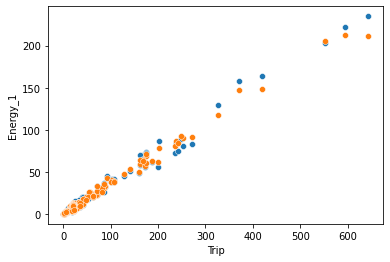

In [531]:
plot_graph(Y_pred)

In [532]:
result=reg.predict(parameters)
result

array([0.81005587, 0.83798883, 0.3349162 , 0.33519553, 0.36396648,
       0.50055866])

In [533]:
min_index = result.argmin()
print("Minimum energy required for the location:",para[min_index])
C

Minimum energy required for the location: C


Trip               1.00
Average_Speeds    13.00
Style              1.00
Motor_Way          0.00
City               1.00
Country_Road       0.00
Tire_Type          0.00
Parking_Heat       0.00
Consumption_1     12.00
devConsumption     0.30
devEnergy          0.02
Name: 5, dtype: float64

In [534]:
parameters

,Trip,Average_Speeds,Style,Motor_Way,City,Country_Road,Tire_Type,Parking_Heat,Consumption_1,devConsumption,devEnergy
1,2.0,18.0,1,0,1,0,1,0,14.5,0.2,-0.01
2,2.0,14.0,1,0,1,0,1,0,15.0,-0.1,0.00
5,1.0,13.0,1,0,1,0,0,0,12.0,0.3,0.02
7,1.0,14.0,1,0,1,0,0,0,12.0,0.5,0.02
10,1.0,13.0,1,0,1,0,0,0,13.0,0.2,0.03
28,1.0,8.0,1,0,1,0,0,0,18.0,-0.1,-0.02
